<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/hands-on-llm-serving-and-optimization/01_inside_the_mind_of_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

💡 NOTE: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4.

This note



In [ ]:
!pip install --quiet transformers tiktoken transformers_stream_generator bertviz


In [2]:
import torch
import gc
import time

# Unload models and clean up gpu memory cache
def free_gpu(model):
  if model:
    # Removes the reference to the model's memory,
    # making it eligible for garbage collection.
    del model

  # Release any cached GPU memory that's no longer needed.
  torch.cuda.empty_cache()

  # Trigger garbage collection to ensure memory is fully released.
  gc.collect()

## Load Model

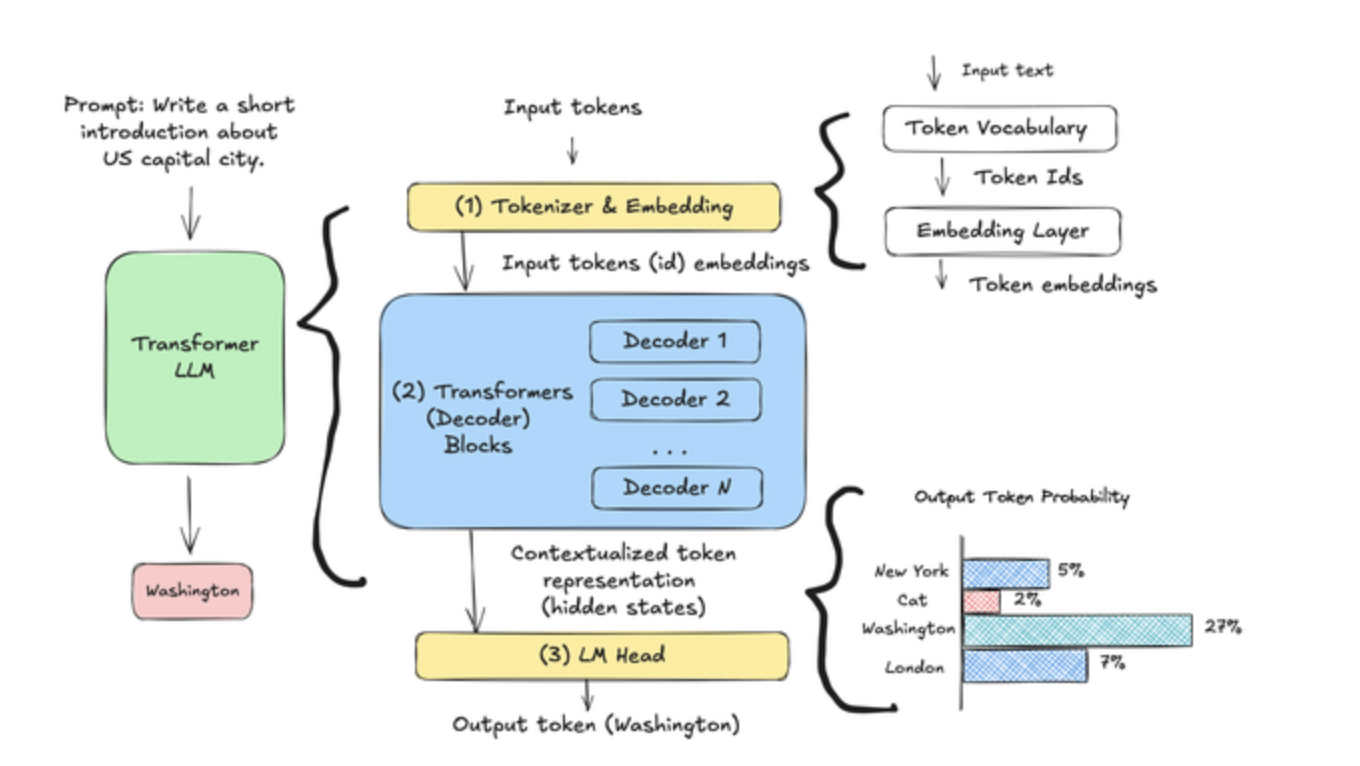

Look at model config, What is model.config?

It's a configuration object that contains all the hyperparameters and settings of the model
It defines the model's architecture, size, and behavior
It's essentially a blueprint of how the model is structured

In [ ]:
from transformers import AutoModelForCausalLM
from pprint import pprint

model_name = "Qwen/Qwen2.5-0.5B"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto"
)

In [4]:
# Print all configuration parameters
config = model.config
print("\n=== Model Configuration Parameters ===")

# Architecture parameters
print("\nArchitecture Parameters:")
print(f"Hidden size: {config.hidden_size}")  # Size of the hidden layers
print(f"Number of layers: {config.num_hidden_layers}")  # Number of transformer blocks
print(f"Number of attention heads: {config.num_attention_heads}")  # Number of attention heads
print(f"Intermediate size: {config.intermediate_size}")  # Size of the MLP intermediate layer

# Tokenizer parameters
print("\nTokenizer Parameters:")
print(f"Vocabulary size: {config.vocab_size}")  # Size of the vocabulary
print(f"Maximum position embeddings: {config.max_position_embeddings}")  # Maximum sequence length

# Print model size
total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel Size:")
print(f"Total parameters: {total_params:,}")

# Model-specific parameters
print("\nModel-specific Parameters:")
for key, value in config.to_dict().items():
    if key not in ['architectures', 'model_type', 'torch_dtype']:
        print(f"{key}: {value}")

# Free GPU memory
free_gpu(model)


=== Model Configuration Parameters ===

Architecture Parameters:
Hidden size: 896
Number of layers: 24
Number of attention heads: 14
Intermediate size: 4864

Tokenizer Parameters:
Vocabulary size: 151936
Maximum position embeddings: 32768

Model Size:
Total parameters: 494,032,768

Model-specific Parameters:
vocab_size: 151936
max_position_embeddings: 32768
hidden_size: 896
intermediate_size: 4864
num_hidden_layers: 24
num_attention_heads: 14
use_sliding_window: False
sliding_window: 32768
max_window_layers: 24
num_key_value_heads: 2
hidden_act: silu
initializer_range: 0.02
rms_norm_eps: 1e-06
use_cache: True
rope_theta: 1000000.0
rope_scaling: None
attention_dropout: 0.0
return_dict: True
output_hidden_states: False
output_attentions: False
torchscript: False
use_bfloat16: False
tf_legacy_loss: False
pruned_heads: {}
tie_word_embeddings: True
chunk_size_feed_forward: 0
is_encoder_decoder: False
is_decoder: False
cross_attention_hidden_size: None
add_cross_attention: False
tie_encoder

## Decoder Block

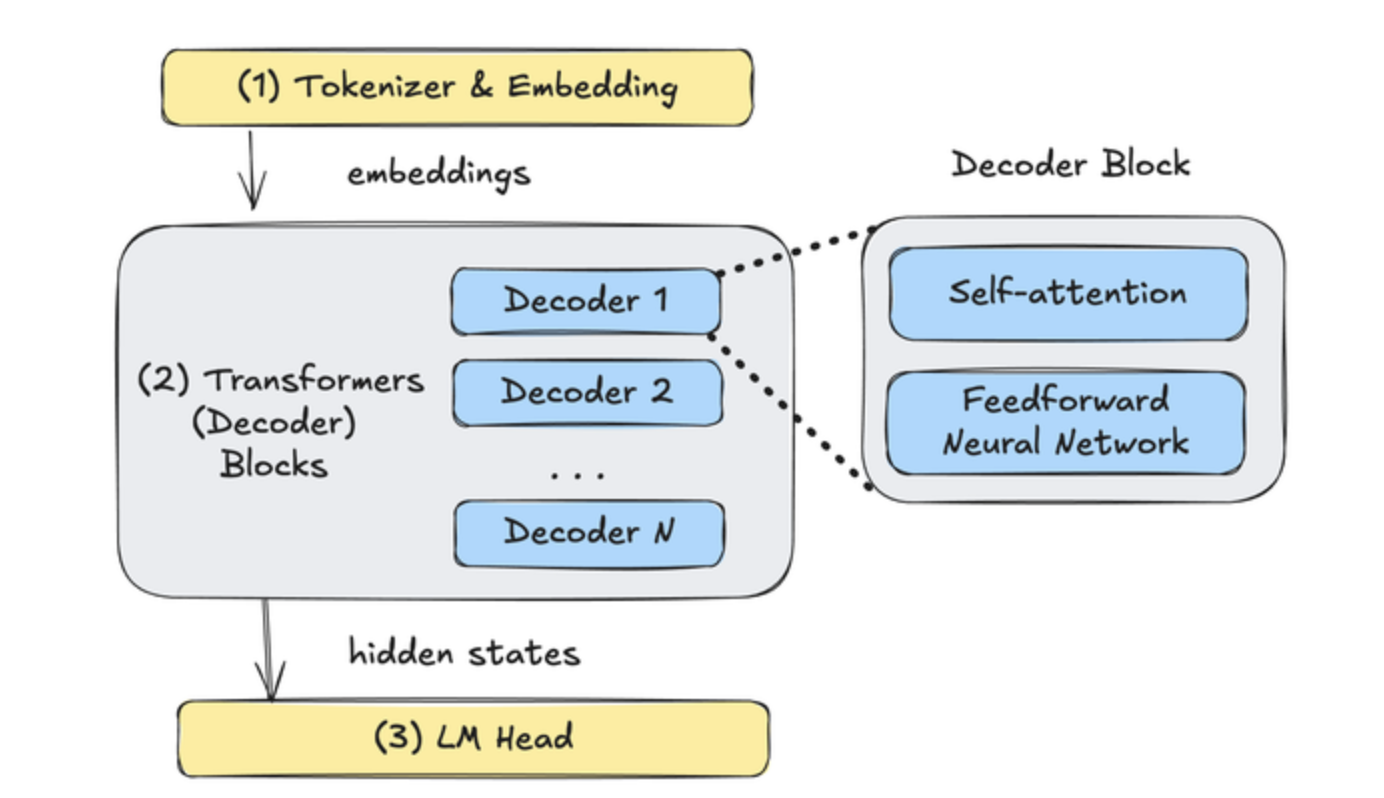

In [5]:
import torch
from transformers import AutoModelForCausalLM
from pprint import pprint


# Load the model
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-0.5B",
    trust_remote_code=True,
    device_map="auto"  # This will automatically handle device placement
)

In [6]:
print(f"\n=== {model_name} Architecture ===")
print("\nModel Configuration:")
# pprint(model.config.to_dict())

print("\nModel Structure:")
def print_module_structure(module, prefix=''):
    for name, child in module.named_children():
        # Skip certain internal modules for clarity
        if name in ['_orig_mod', 'wrapped_model']:
            continue

        # Print the current module
        print(f"{prefix}{name}: {type(child).__name__}")

        if "Qwen2Attention" in name.lower():
          print(f"\nFound attention module: {name}")
          print(f"Type: {type(module).__name__}")

          # Print attention-specific attributes
          if hasattr(module, 'num_heads'):
              print(f"Number of attention heads: {module.num_heads}")
          if hasattr(module, 'head_dim'):
              print(f"Head dimension: {module.head_dim}")
          if hasattr(module, 'hidden_size'):
              print(f"Hidden size: {module.hidden_size}")
          if hasattr(module, 'rotary_emb'):
              print(f"Has rotary embeddings: {module.rotary_emb is not None}")

        # If it's a container module (has children), recurse
        if list(child.children()):
            print_module_structure(child, prefix + '  ')

print_module_structure(model)

free_gpu(model)


=== Qwen/Qwen2.5-0.5B Architecture ===

Model Configuration:

Model Structure:
model: Qwen2Model
  embed_tokens: Embedding
  layers: ModuleList
    0: Qwen2DecoderLayer
      self_attn: Qwen2Attention
        q_proj: Linear
        k_proj: Linear
        v_proj: Linear
        o_proj: Linear
      mlp: Qwen2MLP
        gate_proj: Linear
        up_proj: Linear
        down_proj: Linear
        act_fn: SiLU
      input_layernorm: Qwen2RMSNorm
      post_attention_layernorm: Qwen2RMSNorm
    1: Qwen2DecoderLayer
      self_attn: Qwen2Attention
        q_proj: Linear
        k_proj: Linear
        v_proj: Linear
        o_proj: Linear
      mlp: Qwen2MLP
        gate_proj: Linear
        up_proj: Linear
        down_proj: Linear
        act_fn: SiLU
      input_layernorm: Qwen2RMSNorm
      post_attention_layernorm: Qwen2RMSNorm
    2: Qwen2DecoderLayer
      self_attn: Qwen2Attention
        q_proj: Linear
        k_proj: Linear
        v_proj: Linear
        o_proj: Linear
      mlp: Q

## Attention Layer

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-0.5B",
    trust_remote_code=True,
    device_map="auto"
)

In [ ]:
print(f"\n=== Detailed {model_name} Attention Analysis ===")

# Find all attention layers
attention_layers = []
for name, module in model.named_modules():
    #if "attention" in name.lower():
    if "Qwen2Attention" in type(module).__name__:
        attention_layers.append((name, module))

print(f"\nFound {len(attention_layers)} attention layers")

# Analyze each attention layer
for i, (name, module) in enumerate(attention_layers):
    print(f"\nAttention Layer {i}: {name}")
    print("=" * 50)

    # Basic information
    print(f"Type: {type(module).__name__}")

    # Attention parameters
    if hasattr(module, 'num_heads'):
        print(f"Number of attention heads: {module.num_heads}")
    if hasattr(module, 'head_dim'):
        print(f"Head dimension: {module.head_dim}")
    if hasattr(module, 'hidden_size'):
        print(f"Hidden size: {module.hidden_size}")

    # Rotary embeddings
    if hasattr(module, 'rotary_emb'):
        print(f"Rotary embeddings: {type(module.rotary_emb).__name__ if module.rotary_emb else 'None'}")

    # Attention projections
    print("\nAttention projections:")
    for sub_name, sub_module in module.named_children():
        if hasattr(sub_module, 'weight'):
            shape = sub_module.weight.shape
            print(f"  {sub_name}: {type(sub_module).__name__}, Shape: {shape}")

    # Additional attention-specific attributes
    print("\nAdditional attributes:")
    for attr_name in dir(module):
        if not attr_name.startswith('_') and not callable(getattr(module, attr_name)):
            try:
                value = getattr(module, attr_name)
                if not isinstance(value, (torch.Tensor, torch.nn.Module)):
                    print(f"  {attr_name}: {value}")
            except:
                pass

# Print model's attention-related configuration
print("\nAttention-related configuration:")
config = model.config.to_dict()
attention_config = {k: v for k, v in config.items() if 'attention' in k.lower()}
pprint(attention_config)

free_gpu(model)

Memory Calculation

In [ ]:
def calculate_model_memory():
    # Constants
    hidden_size = 896
    num_layers = 24
    num_heads = 14
    intermediate_size = 4864
    vocab_size = 151936
    max_position = 32768

    # Memory for embeddings
    embedding_memory = vocab_size * hidden_size * 4  # 4 bytes per float32

    # Memory for each transformer block
    # Self-attention
    qkv_memory = hidden_size * hidden_size * 3 * 4  # Q, K, V projections
    attention_output_memory = hidden_size * hidden_size * 4  # Output projection

    # MLP
    mlp_input_memory = hidden_size * intermediate_size * 4  # First MLP layer
    mlp_output_memory = intermediate_size * hidden_size * 4  # Second MLP layer

    # Layer norms
    norm_memory = hidden_size * 4  # Layer normalization parameters

    # Total memory per layer
    layer_memory = (qkv_memory + attention_output_memory +
                   mlp_input_memory + mlp_output_memory +
                   norm_memory * 2)  # 2 layer norms per block

    # Total model memory
    total_memory = (embedding_memory +
                   layer_memory * num_layers)

    # Convert to MB
    total_memory_mb = total_memory / (1024 * 1024)

    return {
        "Embedding Memory (MB)": embedding_memory / (1024 * 1024),
        "Memory per Layer (MB)": layer_memory / (1024 * 1024),
        "Total Model Memory (MB)": total_memory_mb,
        "Total Model Memory (GB)": total_memory_mb / 1024
    }

# Calculate and print memory usage
memory_stats = calculate_model_memory()
print("\n=== Memory Usage Analysis ===")
for key, value in memory_stats.items():
    print(f"{key}: {value:.2f}")

In [ ]:
import torch
from transformers import AutoModelForCausalLM
from pprint import pprint

In [ ]:
# prompt: use bertviz library to visualize the attention result of the input prompt "write a short introduction about US capital city"
from transformers import AutoTokenizer
from bertviz import head_view

# Your input text
text = "The tiny animal was overwhelmed by the confetti and it attempted to bat away the glitter with its little paws."
model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, output_attentions=True)
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True).eval().cuda()

# Tokenize input and get token strings
inputs = tokenizer(text, return_tensors="pt").to(model.device)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Generate outputs with attention
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

# Get attention weights
attention = outputs.attentions

# Use bertviz to visualize
head_view(attention, tokens)
